In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

Form a pandas DataFrame using Available Data. Then apply the columns.

In [97]:
data_dir = "football-prediction/epl-training.csv"
df = pd.read_csv(data_dir)

In [98]:
df.columns = [
    'Date',               
    'Home Team',          
    'Away Team',
    'Full Time Home Goals',  
    'Full Time Away Goals',  
    'Full Time Result',       
    'Half Time Home Goals',  
    'Half Time Away Goals',  
    'Half Time Result',      
    'Referee',
    'Home Shots',             
    'Away Shots',             
    'Home Shots on Target',   
    'Away Shots on Target',   
    'Home Corners',          
    'Away Corners',           
    'Home Fouls',             
    'Away Fouls',             
    'Home Yellow Cards',     
    'Away Yellow Cards',     
    'Home Red Cards',     
    'Away Red Cards'      
]

Insert new features.

In [99]:
df['Home Goal Conversion Rate'] = df['Full Time Home Goals'] / df['Home Shots on Target'].replace(0, 1)
df['Away Goal Conversion Rate'] = df['Full Time Away Goals'] / df['Away Shots on Target'].replace(0, 1)
df['Goal Conversion Rate Difference'] = df['Home Goal Conversion Rate'] - df['Away Goal Conversion Rate']

df['Home Attacking Intensity'] = df['Home Shots'] + df['Home Corners']
df['Away Attacking Intensity'] = df['Away Shots'] + df['Away Corners']
df['Attacking Intensity Difference'] = df['Home Attacking Intensity'] - df['Away Attacking Intensity']

df['Home Disciplinary Pressure'] = df['Home Fouls'] + df['Home Yellow Cards'] + df['Home Red Cards']
df['Away Disciplinary Pressure'] = df['Away Fouls'] + df['Away Yellow Cards'] + df['Away Red Cards']
df['Disciplinary Pressure Difference'] = df['Home Disciplinary Pressure'] - df['Away Disciplinary Pressure']

df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

In [100]:
# takes home and away scores and combines it into a goal difference feature
def compute_features_using_home_team_as_reference(df):
    features_to_differentiate = [
        ('Full Time Home Goals', 'Full Time Away Goals', 'Full Time Goal Difference'),
        ('Half Time Home Goals', 'Half Time Away Goals', 'Half Time Goal Difference'),
        ('Home Shots', 'Away Shots', 'Shot Difference'),
        ('Home Shots on Target', 'Away Shots on Target', 'Shots on Target Difference'),
        ('Home Corners', 'Away Corners', 'Corner Difference'),
        ('Home Fouls', 'Away Fouls', 'Foul Difference'),
        ('Home Yellow Cards', 'Away Yellow Cards', 'Yellow Card Difference'),
        ('Home Red Cards', 'Away Red Cards', 'Red Card Difference')
    ]


    for home_feature, away_feature, new_feature in features_to_differentiate:
        df[new_feature] = df[home_feature] - df[away_feature]

    
    return df

In [101]:
df = compute_features_using_home_team_as_reference(df)

In [102]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by='Date')

# Each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)

In [103]:
# calculates the winstreak length at games played with 
def calculate_home_win_streak(df):
    df['Home Win Streak'] = 0
    for team, team_group in df.groupby('Home Team'):
        win_streak = 0
        for idx, row in team_group.iterrows():
            if row['Match Outcome'] == '1': 
                win_streak += 1
            else:
                win_streak = 0 
            df.at[idx, 'Home Win Streak'] = win_streak

    return df

df = calculate_home_win_streak(df)

In [104]:
# creates a column of recent winning streaks for each home and away team
def win_streak(df, last_x_games=5):
    # finds the recent wins
    def get_recent_performance(team, current_season, current_date, last_x_games):
        # filters the matches for specific team + season + date
        team_matches = df[((df['Home Team'] == team) | (df['Away Team'] == team)) & (df['Season'] == current_season)]
        
        team_matches = team_matches[team_matches['Date'] < current_date]
        team_matches = team_matches.sort_values(by='Date')

        recent_matches = team_matches.tail(last_x_games)
        
        # after filtering, counts the number of recent wins in a row
        wins = 0
        for _, row in recent_matches.iterrows():
            if row['Home Team'] == team and row['Match Outcome'] == 1:
                wins += 1
            elif row['Home Team'] == team and (row['Match Outcome'] == 0 or row['Match Outcome'] == -1):
                wins = 0
            elif row['Away Team'] == team and row['Match Outcome'] == -1:
                wins += 1
            elif row['Away Team'] == team and (row['Match Outcome'] == 0 or row['Match Outcome'] == 1):
                wins = 0

        return wins

    for idx, row in df.iterrows():
        current_season = row['Season']
        current_date = row['Date']
        home_team = row['Home Team']
        away_team = row['Away Team']
        
        home_performance = get_recent_performance(home_team, current_season, current_date, last_x_games)
        away_performance = get_recent_performance(away_team, current_season, current_date, last_x_games)
        #print(f"Home Performance for {home_team}: {home_performance}")
        #print(f"Away Performance for {away_team}: {away_performance}")

        df.loc[idx, 'Recent Performance Home Team'] = home_performance
        df.loc[idx, 'Recent Performance Away Team'] = away_performance
    return df

df = win_streak(df, last_x_games=5)

In [105]:
df.sort_values(by='Date', inplace=True)

In [106]:
df.columns

Index(['Date', 'Home Team', 'Away Team', 'Full Time Home Goals',
       'Full Time Away Goals', 'Full Time Result', 'Half Time Home Goals',
       'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots',
       'Away Shots', 'Home Shots on Target', 'Away Shots on Target',
       'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls',
       'Home Yellow Cards', 'Away Yellow Cards', 'Home Red Cards',
       'Away Red Cards', 'Home Goal Conversion Rate',
       'Away Goal Conversion Rate', 'Goal Conversion Rate Difference',
       'Home Attacking Intensity', 'Away Attacking Intensity',
       'Attacking Intensity Difference', 'Home Disciplinary Pressure',
       'Away Disciplinary Pressure', 'Disciplinary Pressure Difference',
       'Match Outcome', 'Full Time Goal Difference',
       'Half Time Goal Difference', 'Shot Difference',
       'Shots on Target Difference', 'Corner Difference', 'Foul Difference',
       'Yellow Card Difference', 'Red Card Difference', 'Season'

In [107]:
# creates new columns for avg scores/conceeds for home/away teams, per match
def avg_goals_scored_conceded_last_x_games(df, x=5):
    # recency average scores + conceeds
    def calculate_avgs(team, current_season, match_date, x):
        # Filter for matches of the team across the current and previous season
        relevant_matches = df[
            ((df['Home Team'] == team) | (df['Away Team'] == team)) & 
            ((df['Season'] == current_season) | (df['Season'] == current_season - 1))
        ].sort_values(by='Date')

        past_matches = relevant_matches[relevant_matches['Date'] < match_date]
        recent_matches = past_matches.tail(x)
        goals_scored, goals_conceded = 0, 0

        for _, row in recent_matches.iterrows():
            if row['Home Team'] == team:
                goals_scored += row['Full Time Home Goals']
                goals_conceded += row['Full Time Away Goals']
            elif row['Away Team'] == team:
                goals_scored += row['Full Time Away Goals']
                goals_conceded += row['Full Time Home Goals']

        num_matches = len(recent_matches)
        avg_scored = goals_scored / num_matches if num_matches > 0 else None
        avg_conceded = goals_conceded / num_matches if num_matches > 0 else None

        return avg_scored, avg_conceded

    df['Avg Goals Scored Home Last X Games'] = 0.0
    df['Avg Goals Conceded Home Last X Games'] = 0.0
    df['Avg Goals Scored Away Last X Games'] = 0.0
    df['Avg Goals Conceded Away Last X Games'] = 0.0

    running_stats = {}

    for idx, row in df.iterrows():
        for team_type in ['Home Team', 'Away Team']:
            team = row[team_type]
            current_season = row['Season']
            match_date = row['Date']

            if current_season not in running_stats:
                running_stats[current_season] = {}

            if team not in running_stats[current_season]:
                running_stats[current_season][team] = {
                    'scored': [],
                    'conceded': []
                }

            team_stats = running_stats[current_season][team]
            # handle the scenario where the team hasn't played 5 games in the premier league before - at the point where our data starts
            if len(team_stats['scored']) < x:
                team_stats['scored'].append(row['Full Time Home Goals'] if team_type == 'Home Team' else row['Full Time Away Goals'])
                team_stats['conceded'].append(row['Full Time Away Goals'] if team_type == 'Home Team' else row['Full Time Home Goals'])
                avg_scored = sum(team_stats['scored']) / len(team_stats['scored'])
                avg_conceded = sum(team_stats['conceded']) / len(team_stats['conceded'])

            else:
                avg_scored, avg_conceded = calculate_avgs(team, current_season, match_date, x)

            if team_type == 'Home Team':
                df.at[idx, 'Avg Goals Scored Home Last X Games'] = avg_scored
                df.at[idx, 'Avg Goals Conceded Home Last X Games'] = avg_conceded
            else:
                df.at[idx, 'Avg Goals Scored Away Last X Games'] = avg_scored
                df.at[idx, 'Avg Goals Conceded Away Last X Games'] = avg_conceded

    return df

In [108]:
df = avg_goals_scored_conceded_last_x_games(df)

In [109]:
# proxy version of XG, expected goals. 
# Based on goal conversion rate (efficiency of turning shots on target into goals) * attacking intensity (of team)
def proxy_xg(df):
    df['xG Home'] = df['Home Goal Conversion Rate'] * df['Home Attacking Intensity']
    df['xG Away'] = df['Away Goal Conversion Rate'] * df['Away Attacking Intensity']
    df['xG Difference'] = df['xG Home'] - df['xG Away']
    return df
df = proxy_xg(df)

In [110]:
# Team Points = total points in the game. win:3, draw:1, loss:0... DROPPED AFTERWARDS
# Total Points = cumulative sum of the team points, per team, per season
# Point Difference = difference between total points of the teams, per match
def calculate_season_points(df):
    df['Home Team Points'] = 0
    df['Away Team Points'] = 0

    for idx, row in df.iterrows():
        if row['Match Outcome'] == 1:  
            df.at[idx, 'Home Team Points'] = 3
            df.at[idx, 'Away Team Points'] = 0
        elif row['Match Outcome'] == 0: 
            df.at[idx, 'Home Team Points'] = 1
            df.at[idx, 'Away Team Points'] = 1
        elif row['Match Outcome'] == -1:  
            df.at[idx, 'Home Team Points'] = 0
            df.at[idx, 'Away Team Points'] = 3

    df['Home Total Points'] = (df.groupby(['Home Team', 'Season'])['Home Team Points'].cumsum())
    df['Away Total Points'] = (df.groupby(['Away Team', 'Season'])['Away Team Points'].cumsum())
    df['Point Difference'] = df['Home Total Points'] - df['Away Total Points']
    df.drop(columns=['Home Team Points', 'Away Team Points'], inplace=True)

    return df
df = calculate_season_points(df)

In [111]:
df.columns

Index(['Date', 'Home Team', 'Away Team', 'Full Time Home Goals',
       'Full Time Away Goals', 'Full Time Result', 'Half Time Home Goals',
       'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots',
       'Away Shots', 'Home Shots on Target', 'Away Shots on Target',
       'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls',
       'Home Yellow Cards', 'Away Yellow Cards', 'Home Red Cards',
       'Away Red Cards', 'Home Goal Conversion Rate',
       'Away Goal Conversion Rate', 'Goal Conversion Rate Difference',
       'Home Attacking Intensity', 'Away Attacking Intensity',
       'Attacking Intensity Difference', 'Home Disciplinary Pressure',
       'Away Disciplinary Pressure', 'Disciplinary Pressure Difference',
       'Match Outcome', 'Full Time Goal Difference',
       'Half Time Goal Difference', 'Shot Difference',
       'Shots on Target Difference', 'Corner Difference', 'Foul Difference',
       'Yellow Card Difference', 'Red Card Difference', 'Season'

In [112]:
# 2 extra features, difference between recency scores/conceeds of the home/away team. 
df['Difference Average Goals Scored Last X Games'] = df['Avg Goals Scored Home Last X Games'] - df['Avg Goals Scored Away Last X Games']
df['Difference Average Goals Conceded Last X Games'] = df['Avg Goals Conceded Home Last X Games'] - df['Avg Goals Conceded Away Last X Games']

In [113]:
# only keeps 11 specific columns.
def clean_up_columns(df):
    columns_to_keep = [
        'Home Team', 'Away Team', 'Home Win Streak', 'Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games',
        'Point Difference', 'xG Difference', 'Recent Performance Home Team', 'Recent Performance Away Team', 'Disciplinary Pressure Difference', 'Match Outcome'
    ]
    
    df = df[columns_to_keep]
    return df

In [114]:
# last row of DataFrame is NaN
df = df.drop(df.index[-1])

In [115]:
df

,Date,Home Team,Away Team,Full Time Home Goals,Full Time Away Goals,Full Time Result,Half Time Home Goals,Half Time Away Goals,Half Time Result,Referee,...,Avg Goals Scored Away Last X Games,Avg Goals Conceded Away Last X Games,xG Home,xG Away,xG Difference,Home Total Points,Away Total Points,Point Difference,Difference Average Goals Scored Last X Games,Difference Average Goals Conceded Last X Games
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,0.0,4.0,6.571429,0.000000,6.571429,3.0,0.0,3.0,4.0,-4.0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,2.0,4.0,9.600000,7.600000,2.000000,3.0,0.0,3.0,2.0,-2.0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,3.0,1.0,4.666667,6.666667,-2.000000,0.0,3.0,-3.0,-2.0,2.0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,2.0,2.0,5.500000,7.000000,-1.500000,1.0,1.0,0.0,0.0,0.0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,0.0,2.0,5.750000,0.000000,5.750000,3.0,0.0,3.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9218,2024-05-19,Luton,Fulham,2.0,4.0,A,1.0,2.0,A,M Donohue,...,0.8,1.6,10.000000,20.000000,-10.000000,17.0,24.0,-7.0,0.2,1.6
9216,2024-05-19,Crystal Palace,Aston Villa,5.0,0.0,H,2.0,0.0,H,D Bond,...,2.0,1.4,13.888889,0.000000,13.888889,33.0,35.0,-2.0,1.0,-0.6
9217,2024-05-19,Liverpool,Wolves,2.0,0.0,H,2.0,0.0,H,C Kavanagh,...,0.8,2.4,7.142857,0.000000,7.142857,63.0,26.0,37.0,1.6,-0.4
9215,2024-05-19,Chelsea,Bournemouth,2.0,1.0,H,1.0,0.0,H,A Taylor,...,1.2,1.6,7.000000,6.200000,0.800000,42.0,22.0,20.0,1.6,-0.6


In [116]:
# one hot encoding - use for linear models
# For each team x in the league, create a new column Home Team X (value: 1 if team x is playing Home in this match)
def one_hot_encoding(df, col=['Home Team', 'Away Team']):
    return pd.get_dummies(df, columns=col, drop_first=True)

In [117]:
# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team']):
    all_teams = pd.concat([df[c] for c in col]).unique()
    le = LabelEncoder()
    le.fit(all_teams)
    for c in col:
        df[c] = le.transform(df[c])
    return df

If you plan to use tree-based models like XGBoost or Random Forest, normalization and standardization are generally not required since these models are not sensitive to feature scaling. 
However, you still need to handle the categorical features properly (one-hot or label encoding).

Normalize or Standardize the continuous features (Avg Goals, Point Difference, xG Difference) if you're using algorithms sensitive to feature scale (like KNN, SVM, or Neural Networks).
Regularization: Choose based on the model (linear models or neural networks).
DO NOT USE STANDARIZATION AND NORMALIZATION AT THE SAME TIME
LINEAR REGRESIION (OUR BENCHMARK) -->> STANDARIZATION


Normalization (scaling features to have a range between 0 and 1) is typically used when you have features that vary greatly in scale (e.g., Avg Goals Scored might range from 0 to 5, whereas Home Win Streak might range from 0 to 10).
Models like KNN, neural networks, and SVMs generally perform better when the data is normalized.
For features like xG Difference, Avg Goals Scored, or Point Difference, normalizing them can help ensure that they contribute equally to the model's performance.


In [118]:
# normalises a specific set of columns
def normalisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df


Standardization scales the data to have a mean of 0 and a standard deviation of 1. This is useful when features have different ranges and you want to treat them equally.
It is essential for models like logistic regression or SVM when you want to avoid bias towards larger values in the features.


In [119]:
# scales specific columns
def standardisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# Feature Selection Methods

In [120]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df)

,Date,Home Team,Away Team,Full Time Home Goals,Full Time Away Goals,Full Time Result,Half Time Home Goals,Half Time Away Goals,Half Time Result,Referee,Home Shots,Away Shots,Home Shots on Target,Away Shots on Target,Home Corners,Away Corners,Home Fouls,Away Fouls,Home Yellow Cards,Away Yellow Cards,Home Red Cards,Away Red Cards,Home Goal Conversion Rate,Away Goal Conversion Rate,Goal Conversion Rate Difference,Home Attacking Intensity,Away Attacking Intensity,Attacking Intensity Difference,Home Disciplinary Pressure,Away Disciplinary Pressure,Disciplinary Pressure Difference,Match Outcome,Full Time Goal Difference,Half Time Goal Difference,Shot Difference,Shots on Target Difference,Corner Difference,Foul Difference,Yellow Card Difference,Red Card Difference,Season,Home Win Streak,Recent Performance Home Team,Recent Performance Away Team,Avg Goals Scored Home Last X Games,Avg Goals Conceded Home Last X Games,Avg Goals Scored Away Last X Games,Avg Goals Conceded Away Last X Games,xG Home,xG Away,xG Difference,Home Total Points,Away Total Points,Point Difference,Difference Average Goals Scored Last X Games,Difference Average Goals Conceded Last X Games
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0.285714,0.000000,0.285714,23.0,14.0,9.0,14.0,14.0,0.0,1.0,4.0,2.0,9.0,10.0,0.0,1.0,-1.0,0.0,2000.0,0,0.0,0.0,4.0,0.0,0.0,4.0,6.571429,0.000000,6.571429,3.0,0.0,3.0,4.0,-4.0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0.400000,0.400000,0.000000,24.0,19.0,5.0,20.0,16.0,4.0,1.0,2.0,1.0,5.0,5.0,0.0,5.0,-1.0,0.0,2000.0,0,0.0,0.0,4.0,2.0,2.0,4.0,9.600000,7.600000,2.000000,3.0,0.0,3.0,2.0,-2.0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0.333333,0.333333,0.000000,14.0,20.0,-6.0,21.0,24.0,-3.0,-1.0,-2.0,0.0,-10.0,-6.0,4.0,-6.0,2.0,1.0,2000.0,0,0.0,0.0,1.0,3.0,3.0,1.0,4.666667,6.666667,-2.000000,0.0,3.0,-3.0,-2.0,2.0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0.500000,0.333333,0.166667,11.0,21.0,-10.0,12.0,14.0,-2.0,0.0,0.0,-1.0,-7.0,-2.0,-3.0,-2.0,0.0,0.0,2000.0,0,0.0,0.0,2.0,2.0,2.0,2.0,5.500000,7.000000,-1.500000,1.0,1.0,0.0,0.0,0.0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0.250000,0.000000,0.250000,23.0,16.0,7.0,22.0,23.0,-1.0,1.0,2.0,2.0,5.0,2.0,2.0,1.0,-2.0,0.0,2000.0,0,0.0,0.0,2.0,0.0,0.0,2.0,5.750000,0.000000,5.750000,3.0,0.0,3.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9218,2024-05-19,Luton,Fulham,2.0,4.0,A,1.0,2.0,A,M Donohue,15.0,15.0,6.0,7.0,15.0,20.0,4.0,4.0,5.0,4.0,0.0,0.0,0.333333,0.571429,-0.238095,30.0,35.0,-5.0,9.0,8.0,1.0,-1.0,-2.0,-1.0,0.0,-1.0,-5.0,0.0,1.0,0.0,2023.0,0,0.0,0.0,1.0,3.2,0.8,1.6,10.000000,20.000000,-10.000000,17.0,24.0,-7.0,0.2,1.6
9216,2024-05-19,Crystal Palace,Aston Villa,5.0,0.0,H,2.0,0.0,H,D Bond,15.0,8.0,9.0,2.0,10.0,8.0,2.0,4.0,1.0,4.0,0.0,0.0,0.555556,0.000000,0.555556,25.0,16.0,9.0,3.0,8.0,-5.0,1.0,5.0,2.0,7.0,7.0,2.0,-2.0,-3.0,0.0,2023.0,0,2.0,0.0,3.0,0.8,2.0,1.4,13.888889,0.000000,13.888889,33.0,35.0,-2.0,1.0,-0.6
9217,2024-05-19,Liverpool,Wolves,2.0,0.0,H,2.0,0.0,H,C Kavanagh,36.0,4.0,14.0,3.0,14.0,11.0,10.0,2.0,1.0,1.0,0.0,1.0,0.142857,0.000000,0.142857,50.0,15.0,35.0,11.0,4.0,7.0,1.0,2.0,2.0,32.0,11.0,3.0,8.0,0.0,-1.0,2023.0,0,0.0,0.0,2.4,2.0,0.8,2.4,7.142857,0.000000,7.142857,63.0,26.0,37.0,1.6,-0.4
9215,2024-05-19,Chelsea,Bournemouth,2.0,1.0,H,1.0,0.0,H,A Taylor,16.0,22.0,6.0,5.0,5.0,9.0,6.0,5.0,2.0,3.0,0.0,0.0,0.333333,0.200000,0.133333,21.0,31.0,-10.0,8.0,8.0,0.0,1.0,1.0,1.0,-6.0,1.0,-4.0,1.0,-1.0,0.0,2023.0,0,4.0,0.0,2.8,1.0,1.2,1.6,7.000000,6.

Feature Selection: we will create a feature selection voting method. Several different feature selection methods will be incorporated, each will vote on features to drop. The features with the maximum number of votes will be dropped. We will use PCA to find the optimal number of features to keep.

THE ACTUAL FEATURE SELECTION METHODS:

These are the feature selection methods we will investigate: RFE, Information Gain (supervised filter method), Chi-Square Test (supervised filter method), Anova F-Score (supervised filter method, good for 1 nominal var and 1 non-nominal var), zero-variance unsupervised feature selection, high multicollinearity unsupervised feature selection, BORUTA.

Target is Full Time Result (D, H, A).


When we try Linear Regression, we will do 2 versions: one with our implementation of feature selection and one with LASSO regression.

Explained Variance Ratio:  [2.18503330e-01 1.16232275e-01 7.98697844e-02 7.05044061e-02
 5.62898196e-02 4.71788846e-02 4.18259441e-02 3.93128149e-02
 3.71001974e-02 3.24694641e-02 2.73486538e-02 2.62500814e-02
 2.52945492e-02 2.45540172e-02 2.10028203e-02 1.98389740e-02
 1.81937261e-02 1.51428056e-02 1.48881937e-02 1.32557376e-02
 1.13175081e-02 1.04987854e-02 9.67885558e-03 7.66303005e-03
 5.72309265e-03 3.77756586e-03 2.80257054e-03 2.27906133e-03
 1.20305094e-03 3.64524831e-17 3.41665370e-17 2.67020505e-17
 2.42954461e-17 2.17467871e-17 1.70449189e-17 1.60649151e-17
 1.32018521e-17 1.11359052e-17 7.78595027e-18 6.05981530e-18
 2.21045309e-18 4.62173054e-33 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Number of components to retain 95% variance: 21


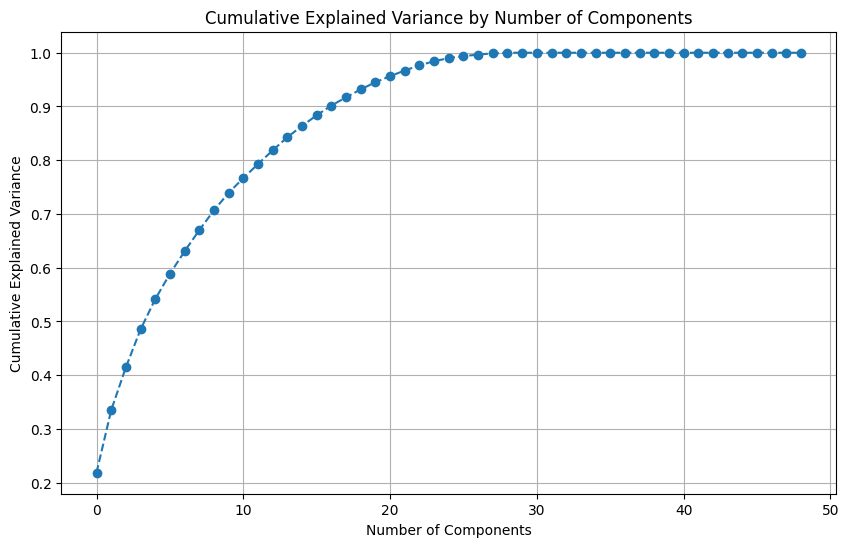

In [140]:
# PCA (must be standardised beforehand)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee', 'Season']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio: ", explained_variance)

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
    print(f"Number of components to retain 95% variance: {n_components}")

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)

PCA shows that the optimal number of features to keep is 21. We will now use other feature selection methods to reduce our dimensionality to 21. Here is the voting mechanism:

In [287]:
class Votes():
    def __init__(self, df):
        featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result', 'Season']
        assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
        df2 = df.drop(featuresToDrop, axis=1)
        self.votes = pd.DataFrame(data=[[0 for _ in range(len(df2.columns))]], columns=list(df2.columns))
    
    def getVotes(self):
        with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
            display(self.votes)

    def addVote(self, key):
        self.votes[key] += 1
    
    def clearVotes(self):
        self.votes = pd.DataFrame(data=[[0 for _ in range(len(df2.columns))]], columns=list(df2.columns))
    
    def sumVotes(self):
        return self.votes.sum().sum()
        
voting_system = Votes(df)
voting_system.getVotes()

,Full Time Home Goals,Full Time Away Goals,Half Time Home Goals,Half Time Away Goals,Half Time Result,Referee,Home Shots,Away Shots,Home Shots on Target,Away Shots on Target,Home Corners,Away Corners,Home Fouls,Away Fouls,Home Yellow Cards,Away Yellow Cards,Home Red Cards,Away Red Cards,Home Goal Conversion Rate,Away Goal Conversion Rate,Goal Conversion Rate Difference,Home Attacking Intensity,Away Attacking Intensity,Attacking Intensity Difference,Home Disciplinary Pressure,Away Disciplinary Pressure,Disciplinary Pressure Difference,Full Time Goal Difference,Half Time Goal Difference,Shot Difference,Shots on Target Difference,Corner Difference,Foul Difference,Yellow Card Difference,Red Card Difference,Home Win Streak,Recent Performance Home Team,Recent Performance Away Team,Avg Goals Scored Home Last X Games,Avg Goals Conceded Home Last X Games,Avg Goals Scored Away Last X Games,Avg Goals Conceded Away Last X Games,xG Home,xG Away,xG Difference,Home Total Points,Away Total Points,Point Difference,Difference Average Goals Scored Last X Games,Difference Average Goals Conceded Last X Games
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next is Recursive Feature Elimination (RFE). Since this type of supervised feature selection (wrapper method) tends to overfit to the model type, we will try 3 different models (Random Forest Classifier, Logistic Regression, Support Vector Machine) and add them to the overall votes. 

In [290]:
# RERUNNING THIS BLOCK HAS THE POTENTIAL TO ADD UNNECESSARY VOTES TO THE VOTING SYSTEM

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from collections import Counter

def recursive_feature_elimination(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee', 'Season']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Full Time Result']
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # SVM cannot work with categorical input and must be converted to label encodings
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(target)
    
    # list of models for RFE to try out
    models = {
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Support Vector Machine": SVC(kernel="linear")
    }

    # dictionary to store selected features for each model
    selected_features = {}

    # actually perform RFE with each model type
    for model_name, model in models.items():
        rfe = RFE(estimator=model, n_features_to_select=number_of_components) # taken from PCA
        if model_name == "Support Vector Machine":
            rfe.fit(data, target)
        else:
            rfe.fit(data, target)
            
        # store the selected feature indices
        selected_features[model_name] = [feature_names[i] for i in range(len(rfe.support_)) if rfe.support_[i]]
        print(f"{model_name} selected features: {selected_features[model_name]}")
        print('\n')
        
    # update voting system
    for model_selected_features in selected_features.values():
        for feature_name in model_selected_features:
            voting_system.addVote(feature_name)
    

recursive_feature_elimination(df)
voting_system.getVotes()

print("\nWe can ensure that the correct number of votes were added by summing the votes: ", voting_system.sumVotes())
print("And by dividing by the number of models (3), we see that the number of votes per model: ", voting_system.sumVotes() // 3)

Random Forest selected features: ['Full Time Home Goals', 'Full Time Away Goals', 'Half Time Home Goals', 'Half Time Away Goals', 'Home Shots on Target', 'Away Shots on Target', 'Home Goal Conversion Rate', 'Away Goal Conversion Rate', 'Goal Conversion Rate Difference', 'Attacking Intensity Difference', 'Full Time Goal Difference', 'Half Time Goal Difference', 'Shot Difference', 'Shots on Target Difference', 'Corner Difference', 'xG Home', 'xG Away', 'xG Difference', 'Home Total Points', 'Away Total Points', 'Point Difference']


Logistic Regression selected features: ['Full Time Home Goals', 'Full Time Away Goals', 'Half Time Home Goals', 'Half Time Away Goals', 'Home Shots on Target', 'Away Shots on Target', 'Home Goal Conversion Rate', 'Away Goal Conversion Rate', 'Goal Conversion Rate Difference', 'Attacking Intensity Difference', 'Full Time Goal Difference', 'Half Time Goal Difference', 'Shots on Target Difference', 'Corner Difference', 'Red Card Difference', 'xG Home', 'xG Away',

,Full Time Home Goals,Full Time Away Goals,Half Time Home Goals,Half Time Away Goals,Half Time Result,Referee,Home Shots,Away Shots,Home Shots on Target,Away Shots on Target,Home Corners,Away Corners,Home Fouls,Away Fouls,Home Yellow Cards,Away Yellow Cards,Home Red Cards,Away Red Cards,Home Goal Conversion Rate,Away Goal Conversion Rate,Goal Conversion Rate Difference,Home Attacking Intensity,Away Attacking Intensity,Attacking Intensity Difference,Home Disciplinary Pressure,Away Disciplinary Pressure,Disciplinary Pressure Difference,Full Time Goal Difference,Half Time Goal Difference,Shot Difference,Shots on Target Difference,Corner Difference,Foul Difference,Yellow Card Difference,Red Card Difference,Home Win Streak,Recent Performance Home Team,Recent Performance Away Team,Avg Goals Scored Home Last X Games,Avg Goals Conceded Home Last X Games,Avg Goals Scored Away Last X Games,Avg Goals Conceded Away Last X Games,xG Home,xG Away,xG Difference,Home Total Points,Away Total Points,Point Difference,Difference Average Goals Scored Last X Games,Difference Average Goals Conceded Last X Games
0,3,3,2,2,0,0,1,0,3,3,1,0,0,0,0,0,1,0,3,3,3,1,1,3,0,0,0,3,3,2,3,2,0,0,1,0,0,0,0,0,0,0,3,3,3,2,2,3,0,0



We can ensure that the correct number of votes were added by summing the votes:  63
And by dividing by the number of models (3), we see that the number of votes per model:  21


Now, we will attempt the supervised filter method: Information Gain. Also known as Mutual Information, this filter method compares the entropies of two variables in order to evaluate the "importance" of the original feature. In other words, it quantifies the amount of information you can extract from one variable about the other variable.

Note: Since Information Gain can be used on nominal and ordinal data, we will keep the target data set unencoded. Furthermore, as Information Gain is invariant to scaling, we will not standardise the data.

Full Time Goal Difference score:                       	1.0578075218417062
xG Difference score:                                   	0.5696462063984518
Goal Conversion Rate Difference score:                 	0.5128898900544172
Full Time Home Goals score:                            	0.3082118251247072
Full Time Away Goals score:                            	0.2599458545294606
Home Goal Conversion Rate score:                       	0.2598623310582422
xG Home score:                                         	0.2430759295591782
Half Time Goal Difference score:                       	0.2339242255147029
xG Away score:                                         	0.2297483971271728
Away Goal Conversion Rate score:                       	0.2211295176999819
Point Difference score:                                	0.2062754233826833
Shots on Target Difference score:                      	0.1233455910388708
Half Time Home Goals score:                            	0.1232303829813572
Away Total Points score: 

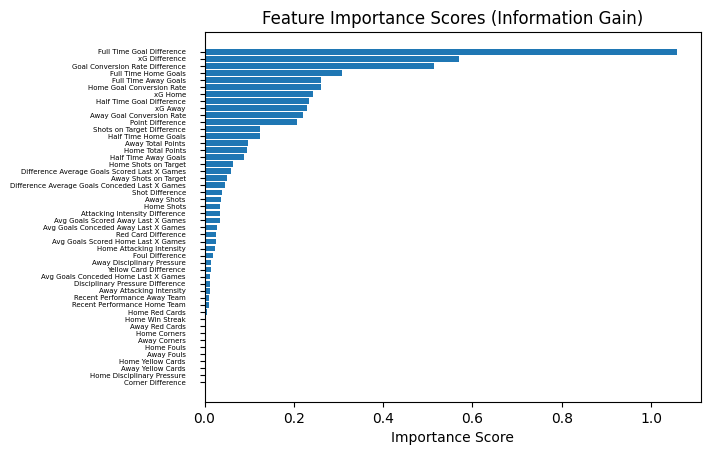

,Full Time Home Goals,Full Time Away Goals,Half Time Home Goals,Half Time Away Goals,Half Time Result,Referee,Home Shots,Away Shots,Home Shots on Target,Away Shots on Target,Home Corners,Away Corners,Home Fouls,Away Fouls,Home Yellow Cards,Away Yellow Cards,Home Red Cards,Away Red Cards,Home Goal Conversion Rate,Away Goal Conversion Rate,Goal Conversion Rate Difference,Home Attacking Intensity,Away Attacking Intensity,Attacking Intensity Difference,Home Disciplinary Pressure,Away Disciplinary Pressure,Disciplinary Pressure Difference,Full Time Goal Difference,Half Time Goal Difference,Shot Difference,Shots on Target Difference,Corner Difference,Foul Difference,Yellow Card Difference,Red Card Difference,Home Win Streak,Recent Performance Home Team,Recent Performance Away Team,Avg Goals Scored Home Last X Games,Avg Goals Conceded Home Last X Games,Avg Goals Scored Away Last X Games,Avg Goals Conceded Away Last X Games,xG Home,xG Away,xG Difference,Home Total Points,Away Total Points,Point Difference,Difference Average Goals Scored Last X Games,Difference Average Goals Conceded Last X Games
0,4,4,3,3,0,0,1,0,4,4,1,0,0,0,0,0,1,0,4,4,4,1,1,3,0,0,0,4,4,3,4,2,0,0,1,0,0,0,0,0,0,0,4,4,4,3,3,4,1,1



We can ensure that the correct number of votes were added by summing the votes:  84
And by dividing by the number of used methods (4), we see that the number of votes per method:  21


In [292]:
# RERUNNING THIS BLOCK HAS THE POTENTIAL TO ADD UNNECESSARY VOTES TO THE VOTING SYSTEM
# code adapted from https://www.stratascratch.com/blog/feature-selection-techniques-in-machine-learning/ 

from sklearn.feature_selection import mutual_info_regression

def mutual_info(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee', 'Season']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Full Time Result']
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # apply information gain
    gain = mutual_info_regression(data, target)
    
    # dictionary of feature importance scores
    scores = {}
    for i in range(len(feature_names)):
        scores[feature_names[i]] = gain[i]
        
    # descending sort by importance score
    sorted_features = sorted(scores.items(), key=lambda x:x[1], reverse=True)
    
    for feature, score in sorted_features:
        print(f"{feature + ' score:':55}\t{score:.16f}")
    
    # plot a bar chat of feature importance scores
    fig, ax = plt.subplots()
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels([feature for feature, score in sorted_features])
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel("Importance Score")
    ax.set_title("Feature Importance Scores (Information Gain)")
    ax.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    # update the voting system
    for feature, _ in sorted_features[:number_of_components]:
        voting_system.addVote(feature)
    
    

mutual_info(df)
voting_system.getVotes()

print("\nWe can ensure that the correct number of votes were added by summing the votes: ", voting_system.sumVotes())
print("And by dividing by the number of used methods (4), we see that the number of votes per method: ", voting_system.sumVotes() // 4)

The next method on our list is Chi-Square Test (another supervised filter method), commonly used on nominal and discrete variables. It compares expected and observed values to create a Chi-Square score. Features with high Chi-Square scores have a higher association with the target data.

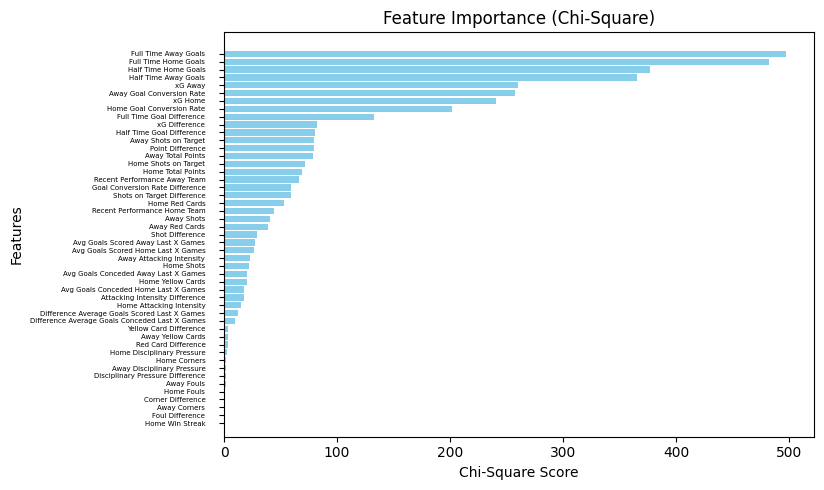

,Full Time Home Goals,Full Time Away Goals,Half Time Home Goals,Half Time Away Goals,Half Time Result,Referee,Home Shots,Away Shots,Home Shots on Target,Away Shots on Target,Home Corners,Away Corners,Home Fouls,Away Fouls,Home Yellow Cards,Away Yellow Cards,Home Red Cards,Away Red Cards,Home Goal Conversion Rate,Away Goal Conversion Rate,Goal Conversion Rate Difference,Home Attacking Intensity,Away Attacking Intensity,Attacking Intensity Difference,Home Disciplinary Pressure,Away Disciplinary Pressure,Disciplinary Pressure Difference,Full Time Goal Difference,Half Time Goal Difference,Shot Difference,Shots on Target Difference,Corner Difference,Foul Difference,Yellow Card Difference,Red Card Difference,Home Win Streak,Recent Performance Home Team,Recent Performance Away Team,Avg Goals Scored Home Last X Games,Avg Goals Conceded Home Last X Games,Avg Goals Scored Away Last X Games,Avg Goals Conceded Away Last X Games,xG Home,xG Away,xG Difference,Home Total Points,Away Total Points,Point Difference,Difference Average Goals Scored Last X Games,Difference Average Goals Conceded Last X Games
0,5,5,4,4,0,0,1,0,5,5,1,0,0,0,0,0,2,0,5,5,5,1,1,3,0,0,0,5,5,3,5,2,0,0,1,0,1,1,0,0,0,0,5,5,5,4,4,5,1,1



We can ensure that the correct number of votes were added by summing the votes:  105
And by dividing by the number of used methods (5), we see that the number of votes per method:  21


In [294]:
# RERUNNING THIS BLOCK HAS THE POTENTIAL TO ADD UNNECESSARY VOTES TO THE VOTING SYSTEM
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee', 'Season']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Full Time Result']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=number_of_components)
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color='skyblue')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    # update the voting system
    for feature in chi2_df['Feature'][:number_of_components]:
        voting_system.addVote(feature)
    
    
chi_square(df)    
voting_system.getVotes()

print("\nWe can ensure that the correct number of votes were added by summing the votes: ", voting_system.sumVotes())
print("And by dividing by the number of used methods (5), we see that the number of votes per method: ", voting_system.sumVotes() // 5)

One Hot Encoding increases the dimensionality of our feature set. Label Encoding does not increase the dimensionality. However, Label Encoding creates an ordering for our teams. Our teams are nominal, not ordinal, so One Hot Encoding is preferred. It creates 144 columns instead of 56 columns. 

In [ ]:
df_one_hot_encoding = one_hot_encoding(df)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df)